In [2]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import qbstyles
from ing_theme_matplotlib import mpl_style
# import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [12]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
T = pd.read_csv('/home/sa42/data/glac/T_models/T.csv')
T = T[[
    'LAT',
    'LON',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS',
    'MAXIMUM_THICKNESS',
]]
glathida = T
glathida = glathida.dropna()

### separate out features - what will be trained to predict desired attribute

In [13]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('MAXIMUM_THICKNESS')
test_labels = test_features.pop('MAXIMUM_THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,48.447838,18.725174
LON,16.513162,53.412789
AREA,21.430462,115.236640
MEAN_SLOPE,15.960784,9.028756
MEAN_THICKNESS,50.313725,42.809574


# Step 2: Setup the Model

### Establish normalization layers

In [14]:
normalizer = {}
variable_list = list(train_features)
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-18 14:33:53.575473: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-18 14:33:53.575615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-18 14:33:53.576969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Single variable linear regression functions

In [15]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss='mean_absolute_error')
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel('Avg Thickness (m)')
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [16]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [17]:
%%time
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 2min 39s, sys: 1min 35s, total: 4min 15s
Wall time: 2min 23s


{'LAT': 62.08962631225586,
 'LON': 68.25149536132812,
 'AREA': 67.83548736572266,
 'MEAN_SLOPE': 67.97136688232422,
 'MEAN_THICKNESS': 27.785175323486328}

In [18]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


    Variable       loss   val_loss
999      LAT  78.008919  94.496674

    Variable       loss    val_loss
999      LON  80.871086  107.957397

    Variable       loss   val_loss
999     AREA  63.517467  93.739899

       Variable       loss   val_loss
999  MEAN_SLOPE  58.019287  73.836334

           Variable       loss   val_loss
999  MEAN_THICKNESS  30.392696  23.990746



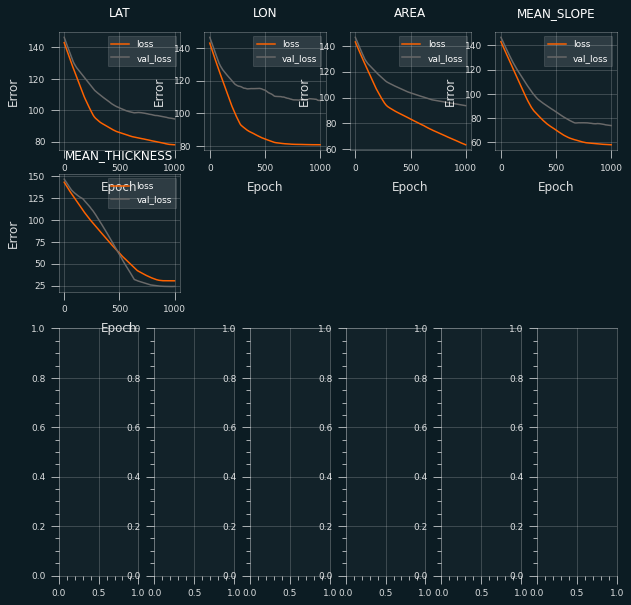

In [20]:
fig,ax=plt.subplots(2,6,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    mpl_style("dark")
    ax = plt.subplot(4,4,i+1)
    plt.subplot(4,4,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [21]:
linear_model = build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 28.854848861694336}

In [22]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



           Variable       loss   val_loss
999  Multi-Variable  15.575064  23.707506


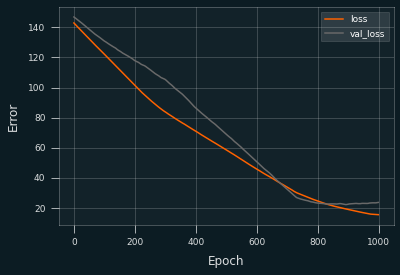

In [23]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [24]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [25]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [26]:
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

{'LAT': 46.10122299194336,
 'LON': 68.8973388671875,
 'AREA': 64.8439712524414,
 'MEAN_SLOPE': 87.75228118896484,
 'MEAN_THICKNESS': 30.506155014038086}

In [27]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print('')


    Variable       loss  val_loss
999      LAT  51.806568  61.00161

    Variable     loss    val_loss
999      LON  77.4617  102.061401

    Variable       loss   val_loss
999     AREA  59.201141  91.268555

       Variable       loss   val_loss
999  MEAN_SLOPE  56.106762  68.389275

           Variable       loss    val_loss
999  MEAN_THICKNESS  17.515457  113.126808



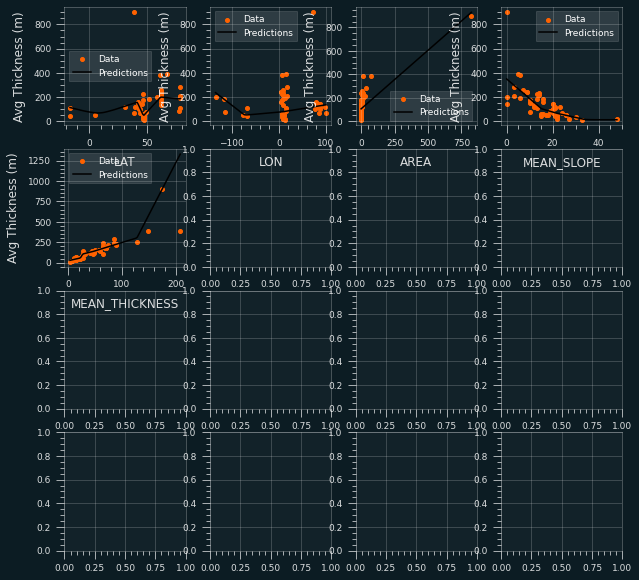

In [28]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

ValueError: num must be 1 <= num <= 4, not 5

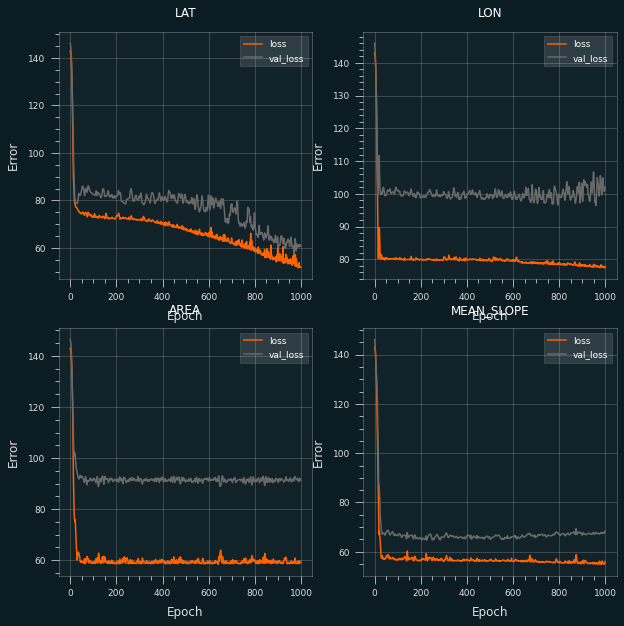

In [42]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [30]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [31]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 40.7 s, sys: 24.6 s, total: 1min 5s
Wall time: 29.2 s


In [32]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


           Variable      loss  val_loss
999  Multi-Variable  9.520209  37.50914


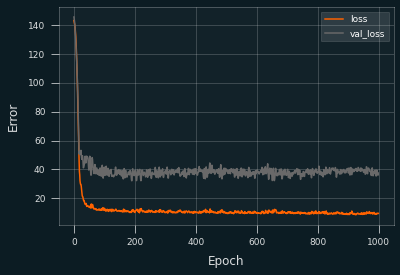

In [33]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 400.0)

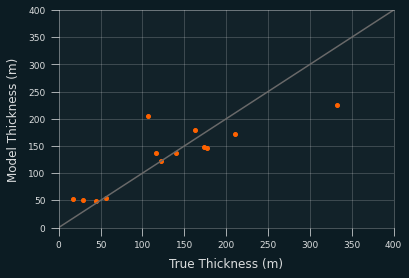

In [39]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,400),(0,400),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,400))
plt.ylim((0,400))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

In [37]:
y

array([[204.59377 ],
       [136.62474 ],
       [ 53.344032],
       [ 48.25803 ],
       [ 55.2606  ],
       [ 50.411762],
       [172.71953 ],
       [226.35713 ],
       [121.97297 ],
       [136.91493 ],
       [148.29828 ],
       [146.07762 ],
       [180.29028 ]], dtype=float32)